In [1]:
# This cell just sets up some nice configuration stuff for making pretty
# figures in Jupyter.
import berrylib.util as util
util.setup_nb()

# An introduction to analyzing trial designs with Imprint.

We're going to analyze a three arm basket trial following the design of [Berry et al. (2013)](https://pubmed.ncbi.nlm.nih.gov/23983156/).

Critically, the log-odds for each arm of the trial are assumed to be drawn from a shared normal distribution. This hierarchical design leads to a sharing effect between the log-odds for the different arms. 

\begin{align}
\mathbf{y} &\sim \mathrm{Binomial}( \mathbf{p}, \mathbf{n})\\
\mathbf{p} &= \mathrm{expit}(\mathbf{\theta} + logit(\mathbf{p_1}))\\
\mathbf{\theta} &\sim N(\mu, \sigma^2)\\
\mu &\sim N(\mu_0, S^2)\\
\sigma^2 &\sim \mathrm{InvGamma}(0.0005, 0.000005)\\
\end{align}

In [2]:
from scipy.special import logit
import matplotlib.pyplot as plt
import numpy as np

n_arms = 3
# This is the binomial n parameter, the number of patients recruited to each arm of the trial.
n_arm_samples = 35

## Step 1: constructing a parameter grid

We're going to use the `pyimprint.grid.make_cartesian_grid_range` function to produce a 3 dimensional grid covering $\theta_i \in [-3.5, 1.0]$. This grid consists of points that lie at the center of (hyper)rectangular cells. The cells cover the whole box.

In [3]:
import pyimprint.grid as grid
n_theta_1d = 16
sim_size = 2000
gr = grid.make_cartesian_grid_range(n_theta_1d, np.full(n_arms, -3.5), np.full(n_arms, 1.0), sim_size)


Next, we need to define the null hypothesis space. There are built-in tools in imprint for defining a null hypothesis as a domain bounded by planes. In this case, the null hypothesis for each arm is defined by $\theta_i < \mathrm{logit}(0.1)$. For $i = 0$, the plane defining this surface is defined by:
\begin{align}
\mathbf{n} \cdot \mathbf{x} = \mathrm{logit}(0.1)\\
\mathbf{n} = (1, 0, 0)
\end{align}
However, we use the convention that the normal vector of the plane will point interior to the null hypothesis, so instead we define a plane:
\begin{align}
\mathbf{n_{interior}} \cdot \mathbf{x} = -\mathrm{logit}(0.1)\\
\mathbf{n_{interior}} = (-1, 0, 0)
\end{align}

Once we have defined these planes, we subdivide the cells created above. This subdivision is done by the `gr.create_tiles` method. For each hyperrectangular cell, the method intersects with the null hypothesis boundaries and splits into multiple tiles whenever a cell is intersected by a null hypothesis plane. 

In [4]:
null_hypos = [
    grid.HyperPlane([-1, 0, 0], -logit(0.1)),
    grid.HyperPlane([0, -1, 0], -logit(0.1)),
    grid.HyperPlane([0, 0, -1], -logit(0.1))
]
gr.create_tiles(null_hypos)

Next, we can optionally prune our grid by calling `gr.prune()`. Pruning will remove any tiles that are entirely in the alternative hypothesis space for all arms. Since our goal is to calculate type I error, we do not care about the alternative hypothesis space. For a false positive to occur, the truth must be negative!

In [5]:

gr.prune()

**At this point, you can skip to the next section if you're not interested in learning about the details of the grid object.**

Here, we'll grab a few of the important variables from the grid range object and examine them. First, let's look at `theta_tiles`. This array represents the center of each tile in the grid. The shape of the array will be `(n_tiles, 3)` because we have 3 parameter values per point.

In [6]:
theta_tiles = grid.theta_tiles(gr)
theta_tiles.shape

(3185, 3)

In [7]:
unique_t2 = np.unique(theta_tiles[:,2])
unique_t2

array([-3.359375, -3.078125, -2.796875, -2.515625, -2.234375, -1.953125,
       -1.671875, -1.390625, -1.109375, -0.828125, -0.546875, -0.265625,
        0.015625,  0.296875,  0.578125,  0.859375])

In the figure below, we plot $\theta_0$ and $\theta_1$ for a couple different values of $\theta_2$. You can see that the shape of the domain in $(\theta_0, \theta_1)$ changes depending on whether $\theta_2$ is in the null space for arm 2 or not. The solid white region without any tile centers in the right figure represents the region where the alternative hypothesis is true for all three arms. The solid black lines represent the boundaries of the arm 0 and the arm 1 null hypothesis boundary planes. 

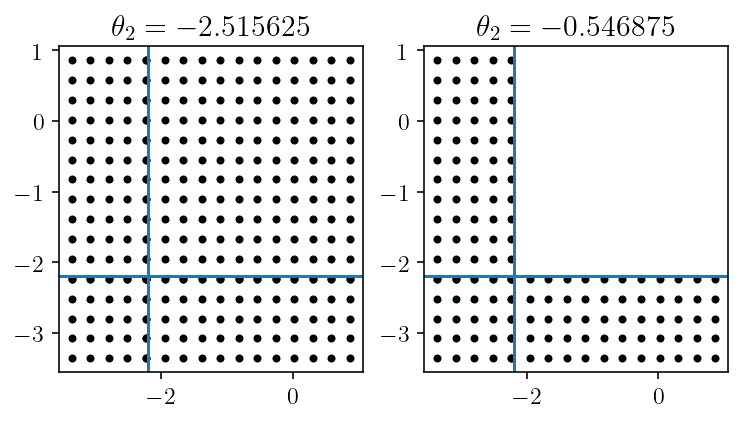

In [8]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title(f'$\\theta_2 = {unique_t2[3]}$')
selection = theta_tiles[:, 2] == unique_t2[3]
plt.plot(theta_tiles[selection,0], theta_tiles[selection, 1], 'k.')
plt.hlines(logit(0.1), -4, 2)
plt.vlines(logit(0.1), -4, 2)
plt.xlim(np.min(theta_tiles[:,0]) - 0.2, np.max(theta_tiles[:,0]) + 0.2)
plt.ylim(np.min(theta_tiles[:,1]) - 0.2, np.max(theta_tiles[:,1]) + 0.2)

plt.subplot(1,2,2)
plt.title(f'$\\theta_2 = {unique_t2[10]}$')
selection = theta_tiles[:, 2] == unique_t2[10]
plt.plot(theta_tiles[selection,0], theta_tiles[selection, 1], 'k.')
plt.hlines(logit(0.1), -4, 2)
plt.vlines(logit(0.1), -4, 2)
plt.xlim(np.min(theta_tiles[:,0]) - 0.2, np.max(theta_tiles[:,0]) + 0.2)
plt.ylim(np.min(theta_tiles[:,1]) - 0.2, np.max(theta_tiles[:,1]) + 0.2)
plt.show()

Let's explore another useful array produced for the grid. The `is_null_per_arm` array will contain whether the null hypothesis is true for each arm for each tile. Naturally, this has the same shape as `theta_tiles`. 

In [9]:
is_null_per_arm = grid.is_null_per_arm(gr)
is_null_per_arm.shape

(3185, 3)

Since we've pruned the grid, the tiles are all in the null hypothesis space for at least one arm.

In [10]:
np.all(np.any(is_null_per_arm, axis=1))

True

The last array that we'll explore is called `n_tiles_per_pt`. To understand this array, we need to return to the tile splitting that occurs in `gr.create_tiles`. Whenever a hypothesis plane splits a cell, that cell is split with one tile for each side of the plane. Since most cells are not split, `n_tiles_per_pt` will be 1 for most input grid points. 

In [11]:
n_tiles_per_pt = grid.n_tiles_per_pt(gr)
n_tiles_per_pt

array([1, 1, 1, ..., 1, 1, 1])

Let's look at the list of input cells which are associated with more than one tile. There are quite a few that are split by a single plane into two tiles. A smaller number that are split by two planes into 3 or 4 tiles. And there is a single input cell that is split into 7 tiles because it is intersected by all three null hypothesis planes! (Why isn't this cell split into 8 tiles? Why are some cells split into 3 tiles?)

In [12]:
n_tiles_per_pt[n_tiles_per_pt > 1]

array([2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 7, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2,

Let's plot up the number of tiles per cell below for a particularly interesting slice!

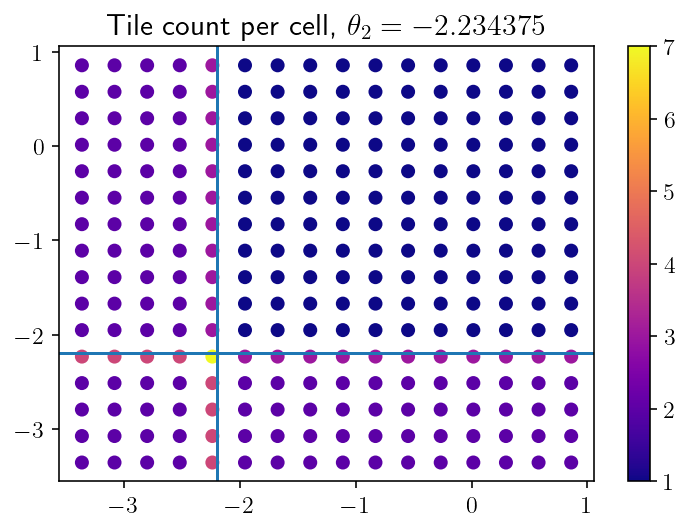

In [13]:
theta = gr.thetas().T
 
selection = (theta[:,2] == unique_t2[4])
plt.title(f'Tile count per cell, $\\theta_2 = {unique_t2[4]}$')
plt.scatter(theta[selection,0], theta[selection,1], c=n_tiles_per_pt[selection])
plt.hlines(logit(0.1), -4, 2)
plt.vlines(logit(0.1), -4, 2)
plt.xlim(np.min(theta[:,0]) - 0.2, np.max(theta[:,0]) + 0.2)
plt.ylim(np.min(theta[:,1]) - 0.2, np.max(theta[:,1]) + 0.2)
plt.colorbar()
plt.show()

## Step 2: Simulating to compute type I error rates and gradients

Now that we've constructed and examined our computation grid, let's actually compute type I error and its gradient.

First, in order to do this, we need to build an inference algorithm that tells us whether to reject or not given a particular dataset. We're going to use an implementation of INLA applied to the model described above. The `fi.rejection_inference` function below will implement this inference algorithm. The details of this inference are not particularly important to what we're doing here so we'll leave it unexplained. Please check out the [intro_to_inla.ipynb](./intro_to_inla.ipynb) notebook if you're interested in learning more. 

First, we'll check that the inference does something reasonable. It rejects the null for arms 1 and 2 where the success counts are 4 and 8 but does not reject the null for arm 0 where the success count is 3. This seems reasonable!

In [15]:
import berrylib.fast_inla as fast_inla
y = [[4,5,9]]
n = [[35,35,35]]
fi = fast_inla.FastINLA(n_arms, critical_value=0.95)
fi.rejection_inference(np.stack((y, n), axis=-1))

DeviceArray([[False,  True,  True]], dtype=bool)

Next, we're going to simulate a lot of datasets! Specifically, we will construct `sim_size` datasets, each consisting of `(n_arm_samples, n_arms)` uniform draws. We construct the datasets this way so that we can threshold the same data many times for each potential set of true parameter values. 

In [32]:
np.random.seed(10)
samples = np.random.uniform(size=(sim_size, n_arm_samples, n_arms))

Next, the meat of the type I error calculation will be done by `binomial_accumulator`. This is a JAX function that will just in time compile into a very fast compiled version when passed a function that implements the rejection inference. Then, we call the JIT function `accumulator` and pass it the necessary information:
* the array of tile centers
* the truth value of each hypothesis for each tile.
* the simulated data.

Internally, this function will simulate `sim_size` trials for each tile and return:
* `typeI_sum`: the number of simulations during which any arm had a false rejections (family-wise error).
* `typeI_score`: the score/gradient of the typeI_sum output with respect to the true parameter values.

Here, we are running 2000 simulations for each of 3185 tiles.

In [33]:
%%time
import berrylib.binomial as binomial
accumulator = binomial.binomial_accumulator(fi.rejection_inference)
typeI_sum, typeI_score = accumulator(theta_tiles, is_null_per_arm, samples)

CPU times: user 1min 20s, sys: 4.47 s, total: 1min 25s
Wall time: 27.9 s


Before continuing, let's look at a couple slices of this type I error grid:

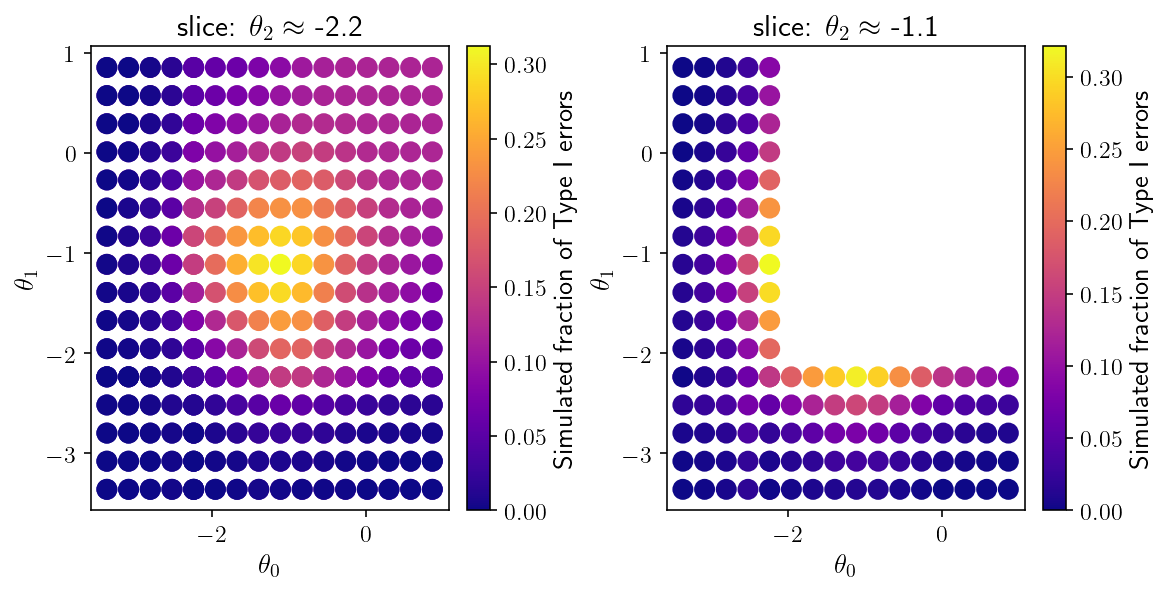

In [34]:
plt.figure(figsize=(8,4), constrained_layout=True)
for i, t2_idx in enumerate([4, 8]):
    t2 = np.unique(theta_tiles[:, 2])[t2_idx]
    selection = (theta_tiles[:,2] == t2)

    plt.subplot(1,2,i+1)
    plt.title(f'slice: $\\theta_2 \\approx$ {t2:.1f}')
    plt.scatter(theta_tiles[selection,0], theta_tiles[selection,1], c=typeI_sum[selection]/sim_size, s=90)
    cbar = plt.colorbar()
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    cbar.set_label('Simulated fraction of Type I errors')
plt.show()

Let's also look at the magnitude of the gradient in the arm-(0,1) plane. Note the correspondence with the areas of rapid change in the simulated fraction of type I error above.

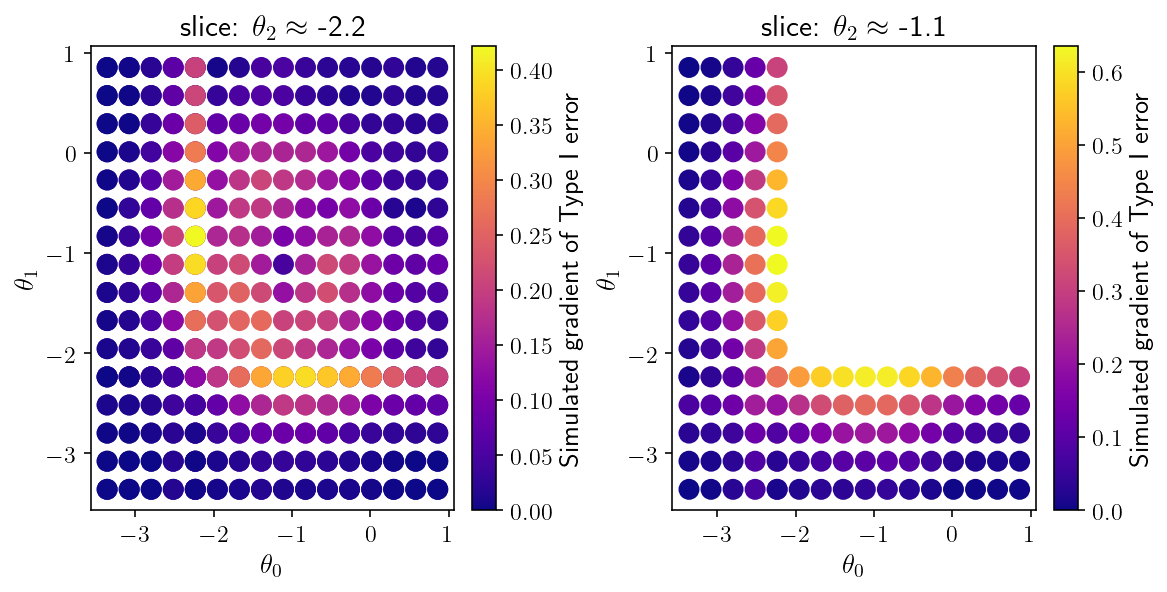

In [35]:
typeI_grad_mag01 = np.linalg.norm(typeI_score[:,[0,1]], axis=1)/sim_size

plt.figure(figsize=(8,4), constrained_layout=True)
for i, t2_idx in enumerate([4, 8]):
    t2 = np.unique(theta_tiles[:, 2])[t2_idx]
    selection = (theta_tiles[:,2] == t2)

    plt.subplot(1,2,i+1)
    plt.title(f'slice: $\\theta_2 \\approx$ {t2:.1f}')
    plt.scatter(theta_tiles[selection,0], theta_tiles[selection,1], c=typeI_grad_mag01[selection], s=90)
    cbar = plt.colorbar()
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    cbar.set_label('Simulated gradient of Type I error')
plt.show()

## Step 3: Bound construction

The final step in analyzing this model is to combine the piece above into a second order upper bound for the true type I error of the form:

\begin{align}
\forall \theta \in \Theta_0 ~~~ P(f(\theta) > g(\theta)) \leq \delta
\end{align}

where:
* $\Theta_0$ is the domain of our grid.
* $f(\theta)$ is the true type I error rate.
* $g(\theta)$ is our type I error rate **bound**.
* $\delta$ is the bound failure rate.

Note that this is a probabilistic bound in that there is a small chance of failure. Even so, any failures are not likely to be egregious due to central tendencies. Below, we set $\delta = 0.025$ and construct the bound $g(\theta)$.

Intuitively, this bound is constructed from the three pieces above:
1. The estimated pointwise type I error provides a starting point with an easily estimated sampling error.
2. The gradient and also a bound on the hessian of the type I error function are used to extrapolate the pointwise bound across each tile using a second order Taylor expansion. 

First, we need to create a `TypeIErrorAccum` object from the `typeI_sum` and `typeI_score` arrays that we computed previously. The code to do this is currently a little messy.

In [36]:
from pyimprint.bound import TypeIErrorAccum
acc_o = TypeIErrorAccum(1, gr.n_tiles(), gr.n_params())
typeI_sum = typeI_sum.astype(np.uint32).reshape((1, -1))
score_sum = typeI_score.flatten()
acc_o.pool_raw(typeI_sum, score_sum)

Next, we haven't implemented the second order bound for the model demonstrated here. Fortunately, it is exactly the same as the second order bound term from a simpler non-hierarchical trial. So, we construct a model object for a `SimpleSelection` and use that as a stand-in for our model here when it comes to bound construction.

In [37]:

from pyimprint.model.binomial import SimpleSelection
simple_selection_model = SimpleSelection(fi.n_arms, n_arm_samples, 1, [])
simple_selection_model.critical_values([fi.critical_value])


Finally, we actually compute the bound.

In [38]:
delta = 0.025
from pyimprint.bound import TypeIErrorBound
ub = TypeIErrorBound()
ub.create(simple_selection_model.make_imprint_bound_state(gr), acc_o, gr, delta)

## Step 4: Bound visualization

For this last step, we're going to visualize the bound a couple different ways. First, we'll just look at the raw bound using matplotlib here in this notebook. Then, we'll open up a Plotly 3D visualization tool.

Note that the upper bound here is going to be quite loose because we have a very coarse grid. The looseness of the bound will be quadratic in cell size because of the second order term. In addition, there is a lot of error in our pointwise type I error estimate because the number of simulations is only 2000.

In [42]:
bound_components = np.array([
    ub.delta_0()[0, :],
    ub.delta_0_u()[0, :],
    ub.delta_1()[0, :],
    ub.delta_1_u()[0, :],
    ub.delta_2_u()[0, :],
    ub.get()[0, :],
]).T

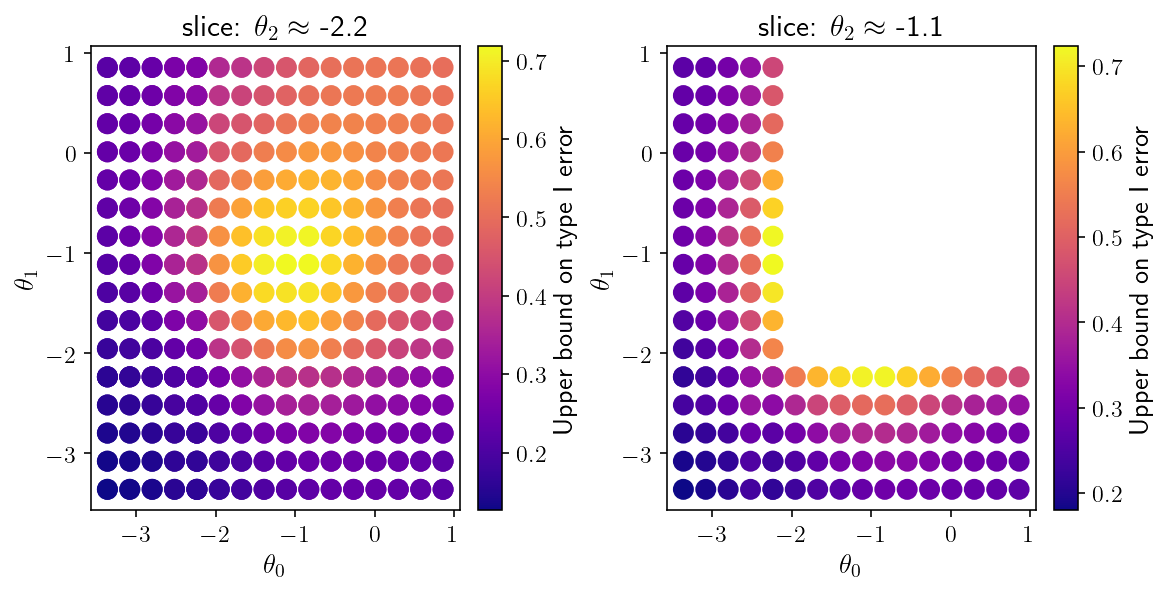

In [43]:
plt.figure(figsize=(8,4), constrained_layout=True)
for i, t2_idx in enumerate([4, 8]):
    t2 = np.unique(theta_tiles[:, 2])[t2_idx]
    selection = (theta_tiles[:,2] == t2)

    plt.subplot(1,2,i+1)
    plt.title(f'slice: $\\theta_2 \\approx$ {t2:.1f}')
    plt.scatter(theta_tiles[selection,0], theta_tiles[selection,1], c=bound_components[selection,5], s=90)
    cbar = plt.colorbar()
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    cbar.set_label('Upper bound on type I error')
plt.show()

In [44]:
t2 = np.unique(theta_tiles[:, 2])[5]
selection = (theta_tiles[:,2] == t2)

np.savetxt('P_tutorial.csv', theta_tiles[selection, :].T, fmt="%s", delimiter=",")
np.savetxt('B_tutorial.csv', bound_components[selection, :], fmt="%s", delimiter=",")

Open [the frontend installation instructions](../../frontend/README.md) and follow them. Copied here:

1. On Mac: `brew install node`. Elsewhere, figure out how to install nodejs!
2. Install reactjs with `npm i react-scripts`

Finally:

```bash
cd frontend
npm start
```

You should see something that looks like: 

<img src="bound_viz_example.png" alt="" width="400"/>

Click on "Upload B matrix" and choose the B matrix we just saved. Do the same for the P matrix. Now you should be able to play around with the 3D visualization! Also, you can select the different layers to see the magnitude of different bound components.